In [5]:
from importlib import reload

import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets('MNIST_data', one_hot=True)
sess = tf.InteractiveSession()

Extracting MNIST_data/train-images-idx3-ubyte.gz


Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [6]:
import ConvNetMnist as CNM
reload(CNM)

net = CNM.ConvNet(sess)
net.train(mnist, n_iter=200)

step 0, training accuracy 0.06


step 100, training accuracy 0.82


test accuracy 0.9066


In [7]:
N = 10
# get N images of '2' from the dataset correctly predicted by the dataset
i = 0
res = []
for (idx, num) in enumerate(mnist.test.labels):
    if num[2] == 1:  # labels are 1-hot encoded
        # check if correctly predicted
        x = mnist.test.images[idx][None, :]
        y = mnist.test.labels[idx][None, :]
        correct = net.test_accuracy(x, y)
        if correct != 1:
            break
        res.append(idx)
        i += 1
        if i >= N:
            break

rows = np.array(res)
twos_x = np.copy(mnist.test.images[rows, :])
twos_y = np.copy(mnist.test.labels[rows, :])

In [10]:
# Restrict the cross entropy calculation to only 2 and 6 labels.
# Then increasing cross entropy is equivalent to moving towards label 6.

out = net.get_raw_output()
y_ = net.get_labels()
x = net.get_input()

out_26 = tf.transpose(tf.gather(tf.transpose(out), indices=[2,6]))
y_26 = tf.transpose(tf.gather(tf.transpose(y_), indices=[2,6]))

cross_entropy_26 = tf.reduce_mean(
    tf.nn.softmax_cross_entropy_with_logits(logits=out_26, labels=y_26)
)

x_grad = tf.gradients(cross_entropy_26, x)[0]
y_pred = tf.argmax(out,1)

fool_x = np.copy(twos_x)
fool_pred = np.argmax(twos_y, axis=1)
print(fool_pred)

while not all([x == 6 for x in fool_pred]):
    x_grad_vals = x_grad.eval(feed_dict = {
       x: fool_x,
       y_: twos_y,
       net.keep_prob: 1.0
    })

    eps = 0.01
    fool_x += eps * np.sign(x_grad_vals)
    fool_pred = y_pred.eval(feed_dict = {
        x: fool_x,
        net.keep_prob: 1.0
    })
    print(fool_pred)

/home/michbad/anaconda3/envs/tensorflow/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[2 2 2 2 2 2]
[2 2 2 2 2 2]
[2 2 2 2 2 2]
[2 2 6 6 6 2]


[8 2 6 6 6 2]
[6 6 6 6 6 6]


In [11]:
no_examples = twos_x.shape[0]
delta_x = twos_x - fool_x

twos_img = twos_x.reshape((no_examples * 28, 28))
fool_img = fool_x.reshape((no_examples * 28, 28))
delta_img = delta_x.reshape((no_examples * 28, 28))

result = np.hstack([twos_img, delta_img, fool_img])
print(result.shape)

(168, 84)


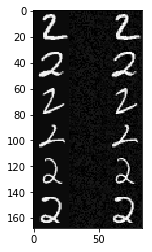

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

# plt.figure(figsize=(200, 100))
plt.imshow(result, cmap='gray')